# LightGBM + XGBoost + SVM

### Business Background

The titanic.csv file contains data for 887 of the real Titanic passengers. Each row represents one person. The columns describe different attributes about the person including whether they survived , their age, their passenger-class, their sex and the fare they paid. By using the LightGBM, XGBoost and SVM, I predict the passengers who can survive or not.

In [1]:
import sys
sys.path.append('/Users/owenwei/opt/anaconda3/lib/python3.9/site-packages')
import pandas as pd
import numpy as np
from sklearn import preprocessing
import matplotlib.pyplot as plt 
plt.rc("font", size=14)

from sklearn.model_selection import train_test_split
import seaborn as sns
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)

from imblearn.over_sampling import SMOTE
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

import lightgbm as lgb
from sklearn.tree import export_graphviz
import pydot
import graphviz


In [2]:
df = pd.read_csv('titanic.csv')
df

,Survived,Pclass,Name,Sex,Age,Siblings/Spouses Aboard,Parents/Children Aboard,Fare
0,0,3,Mr. Owen Harris Braund,male,22.0,1,0,7.2500
1,1,1,Mrs. John Bradley (Florence Briggs Thayer) Cum...,female,38.0,1,0,71.2833
2,1,3,Miss. Laina Heikkinen,female,26.0,0,0,7.9250
3,1,1,Mrs. Jacques Heath (Lily May Peel) Futrelle,female,35.0,1,0,53.1000
4,0,3,Mr. William Henry Allen,male,35.0,0,0,8.0500
...,...,...,...,...,...,...,...,...
882,0,2,Rev. Juozas Montvila,male,27.0,0,0,13.0000
883,1,1,Miss. Margaret Edith Graham,female,19.0,0,0,30.0000
884,0,3,Miss. Catherine Helen Johnston,female,7.0,1,2,23.4500
885,1,1,Mr. Karl Howell Behr,male,26.0,0,0,30.0000


### EDA

In [3]:
#check duplicated data
print(len(df['Name'].unique()))
# drop the Name
df = df.drop(columns = 'Name')

887


In [4]:
#transfer Sex to 0 as female and 1 as male
df['Sex'] = df['Sex'].map({'female': 0, 'male': 1})

In [5]:
df.describe()

,Survived,Pclass,Sex,Age,Siblings/Spouses Aboard,Parents/Children Aboard,Fare
count,887.000000,887.000000,887.000000,887.000000,887.000000,887.000000,887.00000
mean,0.385569,2.305524,0.645998,29.471443,0.525366,0.383315,32.30542
std,0.487004,0.836662,0.478480,14.121908,1.104669,0.807466,49.78204
min,0.000000,1.000000,0.000000,0.420000,0.000000,0.000000,0.00000
25%,0.000000,2.000000,0.000000,20.250000,0.000000,0.000000,7.92500
50%,0.000000,3.000000,1.000000,28.000000,0.000000,0.000000,14.45420
75%,1.000000,3.000000,1.000000,38.000000,1.000000,0.000000,31.13750
max,1.000000,3.000000,1.000000,80.000000,8.000000,6.000000,512.32920


In [6]:
def eda_histgoram(df, features):
    for feature in features:
        plt.title(feature)
        plt.hist(df[feature], 
            color = 'blue', 
            edgecolor = 'black',
            bins = 100)
        plt.show()

In [7]:
def plot_hist(df):
    # Get list of column names
    columns = df.columns.tolist()

    # Loop through columns and plot histogram for each
    for col in columns:
        plt.hist(df[col])
        plt.title(col)
        plt.xlabel('Value')
        plt.ylabel('Frequency')
        plt.show()

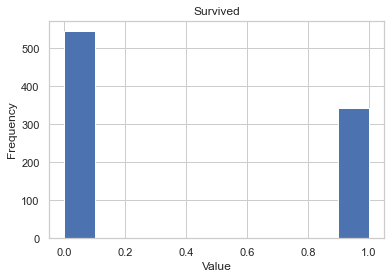

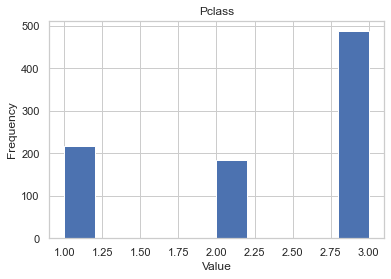

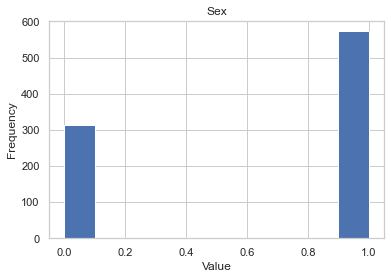

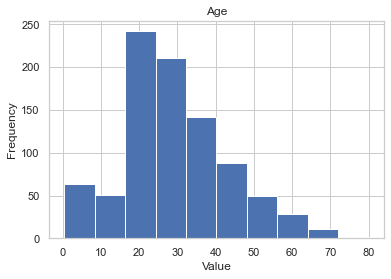

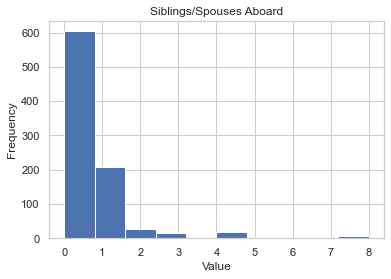

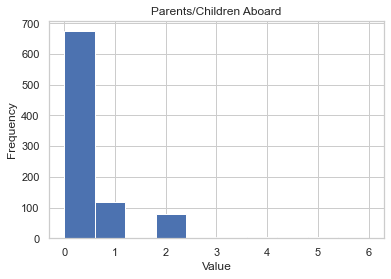

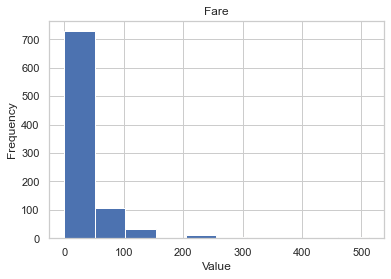

In [8]:
plot_hist(df)

### Split the train and test data

In [9]:
# Extract the target column using pop()
Y = df.pop('Survived')
# Extract the feature columns (i.e., all columns except 'Target') using drop()
X = df

In [10]:
## we simply separate the dataset to 70% dataset as train dataset and 30% dataset test dataset
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=0)

(array([383.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 237.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

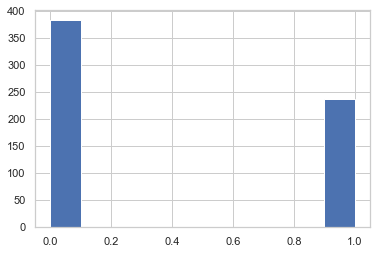

In [11]:
# Check the balance of the train data
plt.hist(Y_train)

#### SMOTE algorithm (Synthetic Minority Oversampling Technique)
Balancing the labeling 0 and 1 in dataset

In [12]:
os = SMOTE(random_state=0)
X_2 = X_train
Y_2 = Y_train

In [13]:
columns = X_2.columns
os_data_X_2, os_data_Y_2 = os.fit_resample(X_2, Y_2)
os_data_X_2 = pd.DataFrame(data=os_data_X_2,columns=columns )
os_data_Y_2 = pd.DataFrame(data=os_data_Y_2,columns=['Survived'])
# we can Check the numbers of our data
print("length of oversampled data is ",len(os_data_X_2))
print("Number of 0 in oversampled data",len(os_data_Y_2[os_data_Y_2['Survived']==0]))
print("Number of 1 in oversampled data",len(os_data_Y_2[os_data_Y_2['Survived']==1]))
print("Proportion of 0 in oversampled data is ",len(os_data_Y_2[os_data_Y_2['Survived']==0])/len(os_data_X_2))
print("Proportion of 1 in oversampled data is ",len(os_data_Y_2[os_data_Y_2['Survived']==1])/len(os_data_X_2))

length of oversampled data is  766
Number of 0 in oversampled data 383
Number of 1 in oversampled data 383
Proportion of 0 in oversampled data is  0.5
Proportion of 1 in oversampled data is  0.5


In [14]:
X_train = os_data_X_2
Y_train = os_data_Y_2

(array([383.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 383.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

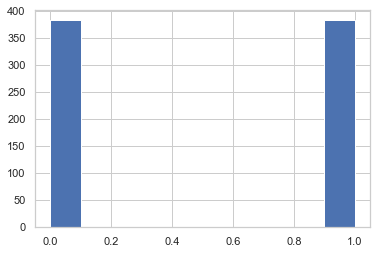

In [15]:
# Check the balance of the train data
plt.hist(Y_train)

### Apply GridSearchCV to find the best hyperparameters

In [16]:
# Define parameter grid
param_grid = {
    'num_leaves': [30, 50, 100],
    'max_depth': [5, 10, 15],
    'learning_rate': [0.05, 0.1, 0.2],
}

In [17]:
# Create LightGBM model
lgb_model = lgb.LGBMClassifier()

# Define GridSearchCV object
grid_search = GridSearchCV(lgb_model, param_grid=param_grid, cv=5)

# Fit the GridSearchCV object to the data
grid_search.fit(X_train, Y_train)

# Print the best parameters and score
print('Best parameters:', grid_search.best_params_)
print('Best score:', grid_search.best_score_)

/opt/anaconda3/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (

Best parameters: {'learning_rate': 0.05, 'max_depth': 10, 'num_leaves': 30}
Best score: 0.8524828113063407


/opt/anaconda3/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (

### Run the LightGBM Model

In [18]:
clf = lgb.LGBMClassifier(boosting_type='gbdt', objective='binary', num_leaves=30, learning_rate=0.05, max_depth=10, random_state=88)
clf.fit(X_train, Y_train)

/opt/anaconda3/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LGBMClassifier(learning_rate=0.05, max_depth=10, num_leaves=30,
               objective='binary', random_state=88)

In [19]:
# predict the results
Y_pred=clf.predict(X_test)
y_pred_prob = clf.predict_proba(X_test)[:,1]

### Model Performance

In [20]:
accuracy=accuracy_score(Y_pred, Y_test)
print('LightGBM Model accuracy score: {0:0.4f}'.format(accuracy_score(Y_test, Y_pred)))

LightGBM Model accuracy score: 0.8015


In [21]:
cm = confusion_matrix(Y_test, Y_pred)
print(cm)
print(classification_report(Y_test, Y_pred))

[[140  22]
 [ 31  74]]
              precision    recall  f1-score   support

           0       0.82      0.86      0.84       162
           1       0.77      0.70      0.74       105

    accuracy                           0.80       267
   macro avg       0.79      0.78      0.79       267
weighted avg       0.80      0.80      0.80       267



<AxesSubplot:>

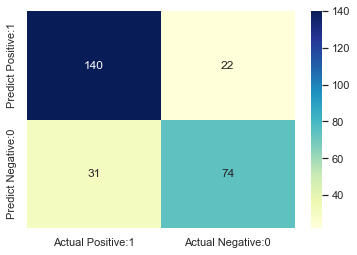

In [22]:
cm_matrix = pd.DataFrame(data=cm, columns=['Actual Positive:1', 'Actual Negative:0'], 
                                 index=['Predict Positive:1', 'Predict Negative:0'])

sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

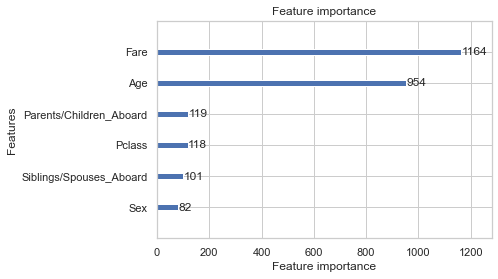

In [23]:
lgb.plot_importance(clf)

In [24]:
def plotProbabilityDistribution(Y_pred,Y_test):
    df_matrix = pd.DataFrame()
    df_matrix["test"] = Y_test
    df_matrix["predict"] = Y_pred
    
    plt.figure(figsize=(16,10))
    plt.xticks(fontsize = 20)
    plt.yticks(fontsize = 20)
    plt.xlabel("Confidence Level", fontsize = 20)
    
    plt.hist(df_matrix['predict'],
         color = 'blue',
         edgecolor = 'black',
         bins = 100,)
    
    return df_matrix

,test,predict
14,0,0.959203
158,0,0.293906
762,0,0.079981
740,1,0.207247
482,0,0.045728
...,...,...
619,1,0.036059
819,1,0.478362
64,1,0.770245
880,0,0.121412


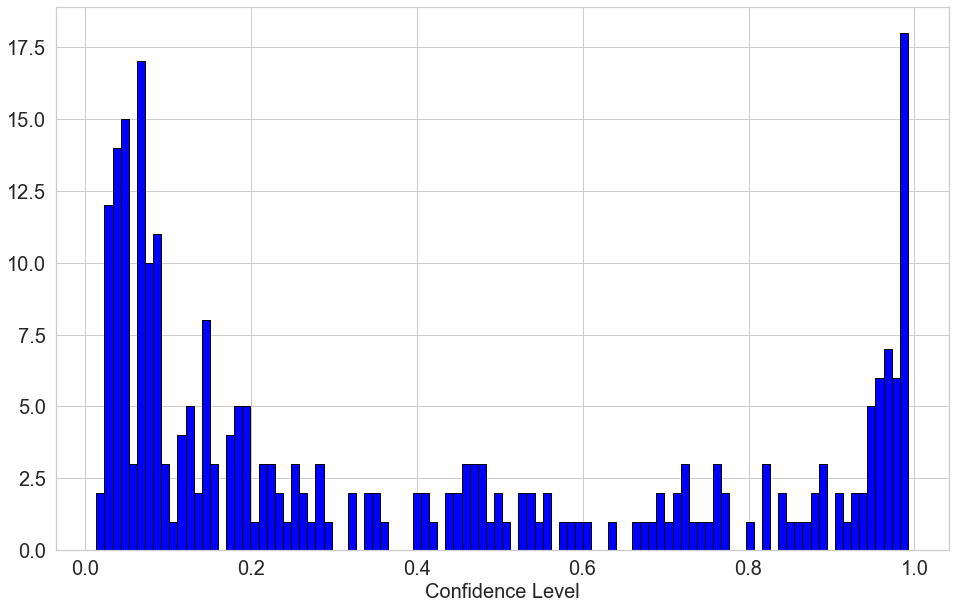

In [25]:
plotProbabilityDistribution(y_pred_prob,Y_test)

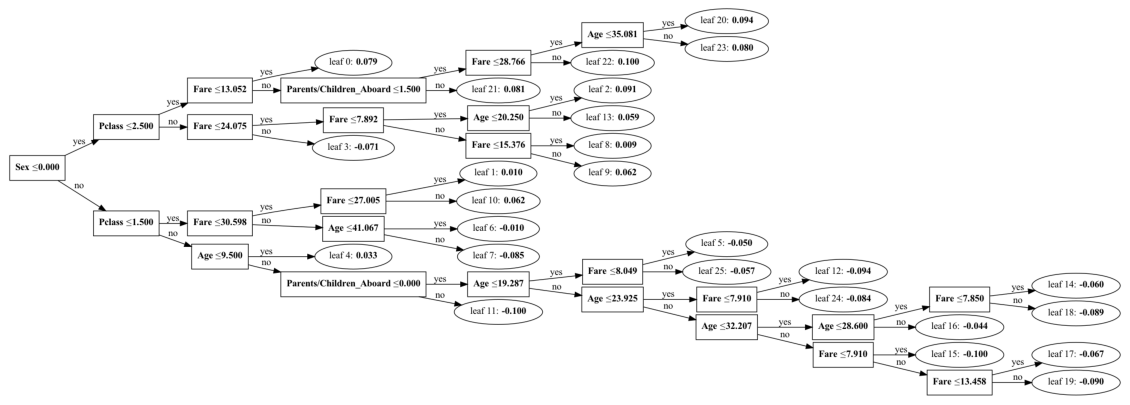

In [26]:
# Plot the decision tree
lgb.plot_tree(clf, figsize=(20, 10))
plt.show()

### Optimization in threshold by G-Mean

In [27]:
# Based on G-Mean to find the best threshold
def rocPlotAndBestThreshold(Y_test,X_test):
    # predict the results
    Y_pred=clf.predict(X_test)
    y_pred_prob = clf.predict_proba(X_test)[:,1]
    
    logit_roc_auc = roc_auc_score(Y_test, Y_pred)
    fpr, tpr, thresholds = roc_curve(Y_test, y_pred_prob)
    
    # calculate the g-mean for each threshold
    gmeans = np.sqrt(tpr * (1-fpr))
    
    # locate the index of the largest g-mean
    ix = np.argmax(gmeans)
    print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))
    
    plt.figure()
    plt.plot(fpr, tpr, label='(area = %0.2f)' % logit_roc_auc)
    plt.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.savefig('Log_ROC')
    plt.show()
    
    return thresholds[ix]

Best Threshold=0.399571, G-Mean=0.801


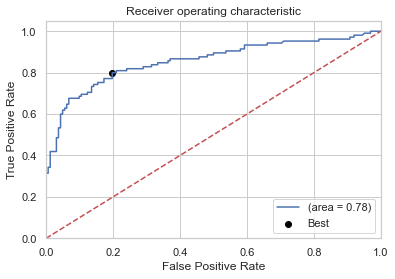

In [28]:
threshold=rocPlotAndBestThreshold(Y_test,X_test)

In [29]:
# the function to change the thresholds
def probs_to_prediction(probs, threshold):
    pred=[]
    for x in probs:
        if x>threshold:
            pred.append(1)
        else:
            pred.append(0)
    return pred

In [30]:
Y_pred_GMEAN = probs_to_prediction(y_pred_prob, threshold)

In [31]:
cm_GMEAN = confusion_matrix(Y_test, Y_pred_GMEAN)
print(cm_GMEAN)
print(classification_report(Y_test, Y_pred_GMEAN))

[[130  32]
 [ 22  83]]
              precision    recall  f1-score   support

           0       0.86      0.80      0.83       162
           1       0.72      0.79      0.75       105

    accuracy                           0.80       267
   macro avg       0.79      0.80      0.79       267
weighted avg       0.80      0.80      0.80       267

